In [1]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

In [2]:
dim = 512 
test_dir = f'/kaggle/input/vinbigdata-{dim}-image-dataset/vinbigdata/test'
weights_dir = '/kaggle/input/v1-10-percent-train/yolov5/runs/train/exp/weights/best.pt'

In [3]:


test_df = pd.read_csv(f'/kaggle/input/vinbigdata-{dim}-image-dataset/vinbigdata/test.csv')
test_df.head()



image_id  width  height
0  83caa8a85e03606cf57e49147d7ac569   2304    2880
1  7550347fa2bb96c2354a3716dfa3a69c   2538    3095
2  74b23792db329cff5843e36efb8aa65a   2788    3120
3  94568a546be103177cb582d3e91cd2d8   1994    2430
4  6da36354fc904b63bc03eb3884e0c35c   2056    2376

In [4]:
shutil.copytree('/kaggle/input/yolov5-official-v31-dataset/yolov5', '/kaggle/working/yolov5')
os.chdir('/kaggle/working/yolov5') # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.7.0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [5]:
!python detect.py --weights $weights_dir\
--img 640\
--conf 0.01\
--iou 0.4\
--source $test_dir\
--save-txt --save-conf --exist-ok

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.01, device='', exist_ok=True, img_size=640, iou_thres=0.4, name='exp', project='runs/detect', save_conf=True, save_txt=True, source='/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test', update=False, view_img=False, weights=['/kaggle/input/v1-10-percent-train/yolov5/runs/train/exp/weights/best.pt'])
Fusing layers... 
image 1/3000 /kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test/002a34c58c5b758217ed1f584ccbcfe9.png: 640x640 1 Aortic enlargements, 1 Cardiomegalys, 5 Pleural thickenings, Done. (0.057s)
image 2/3000 /kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test/004f33259ee4aef671c2b95d54e4be68.png: 640x640 2 Aortic enlargements, 1 Cardiomegalys, 1 Pleural thickenings, Done. (0.050s)
image 3/3000 /kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test/008bdde2af2462e86fd373a445d0f4cd.png: 640x640 1 Aortic enlargements, 1 Cardiomegalys, 1 Nodule/Masss, 1 Pleural thickenings, Done. (0.046

100%|██████████| 16/16 [00:00<00:00, 118.83it/s]


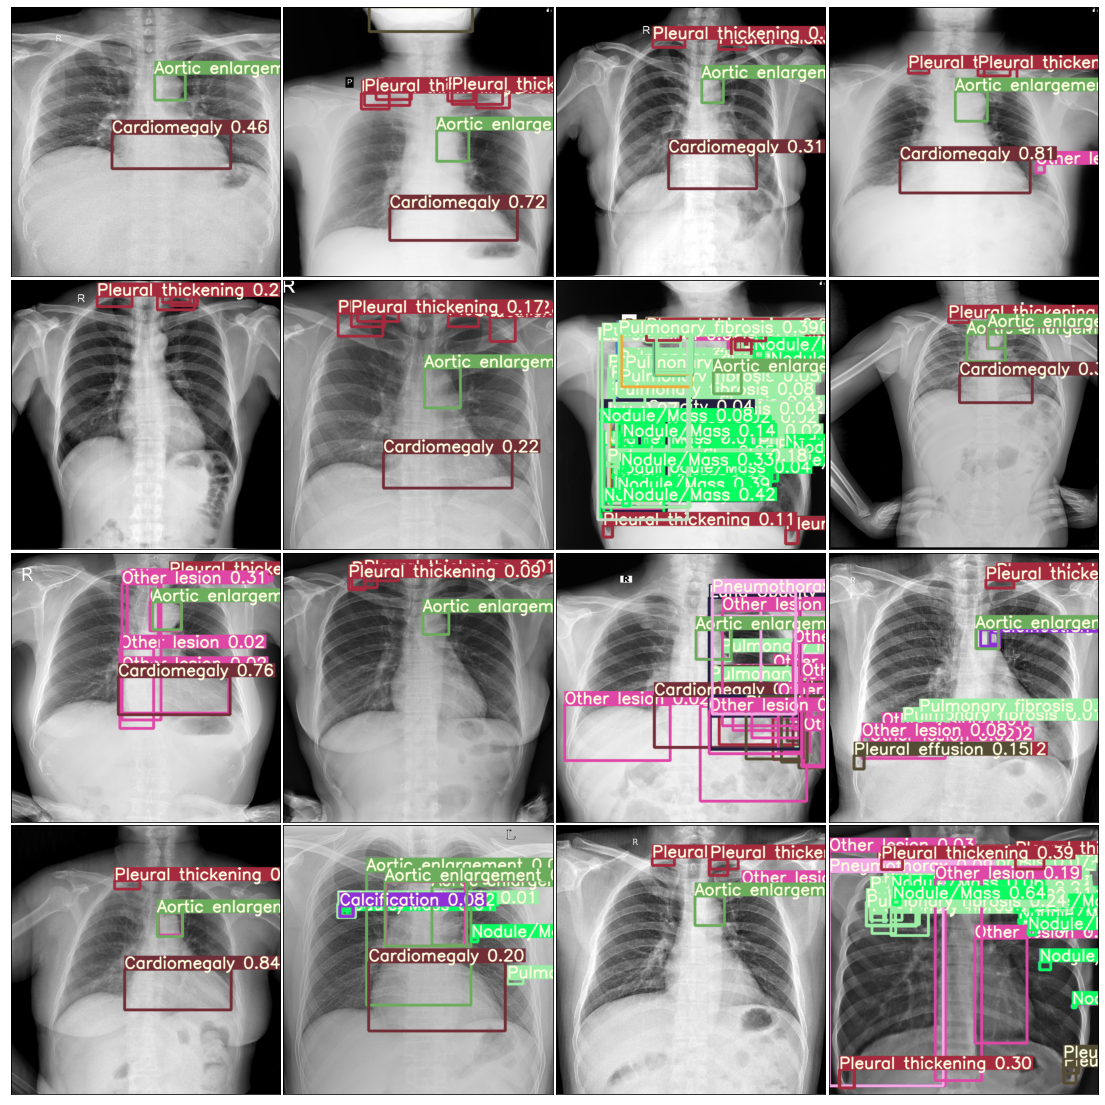

100%|██████████| 16/16 [00:00<00:00, 125.27it/s]


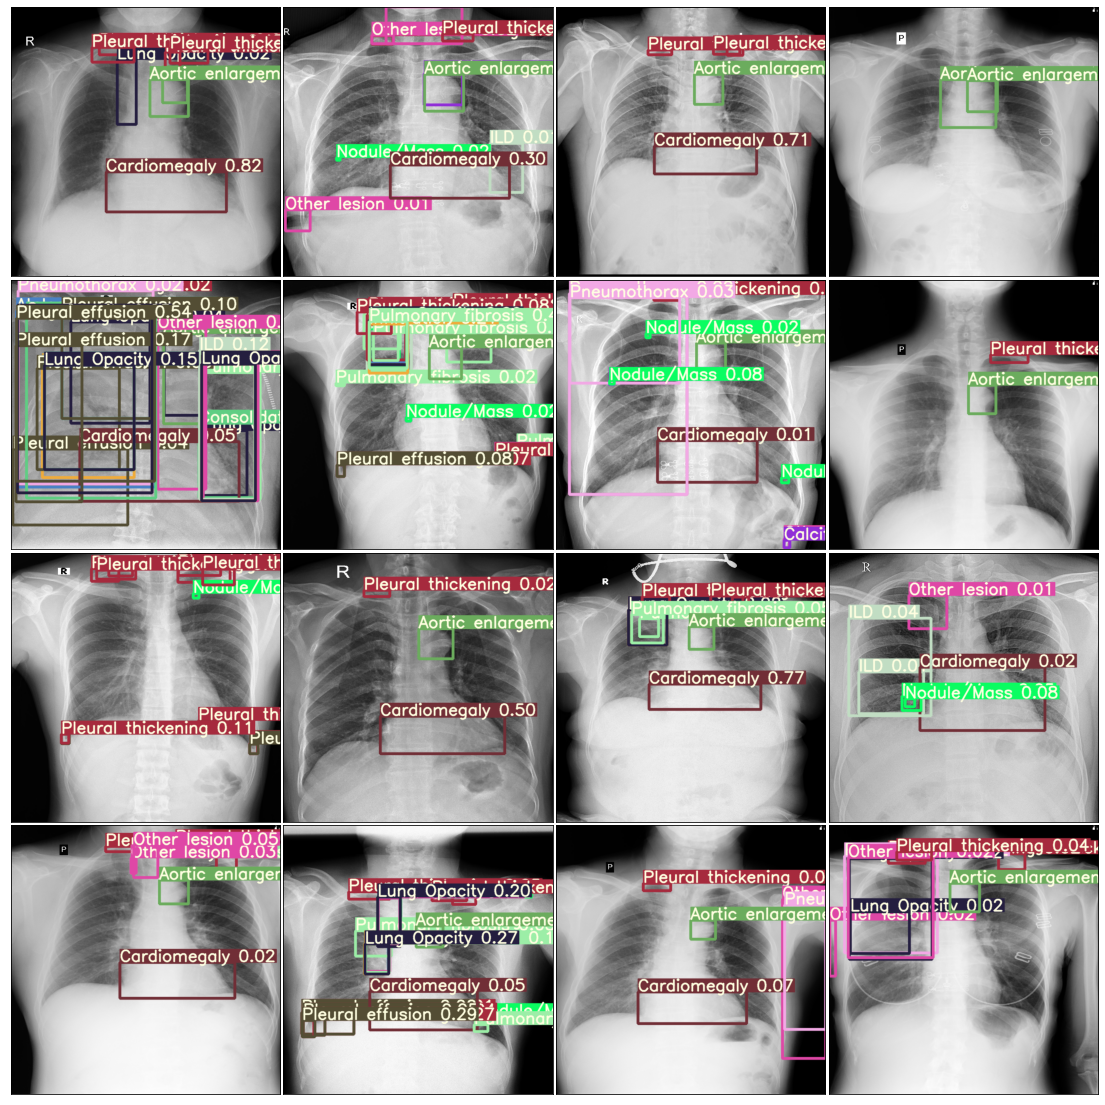

100%|██████████| 16/16 [00:00<00:00, 110.39it/s]


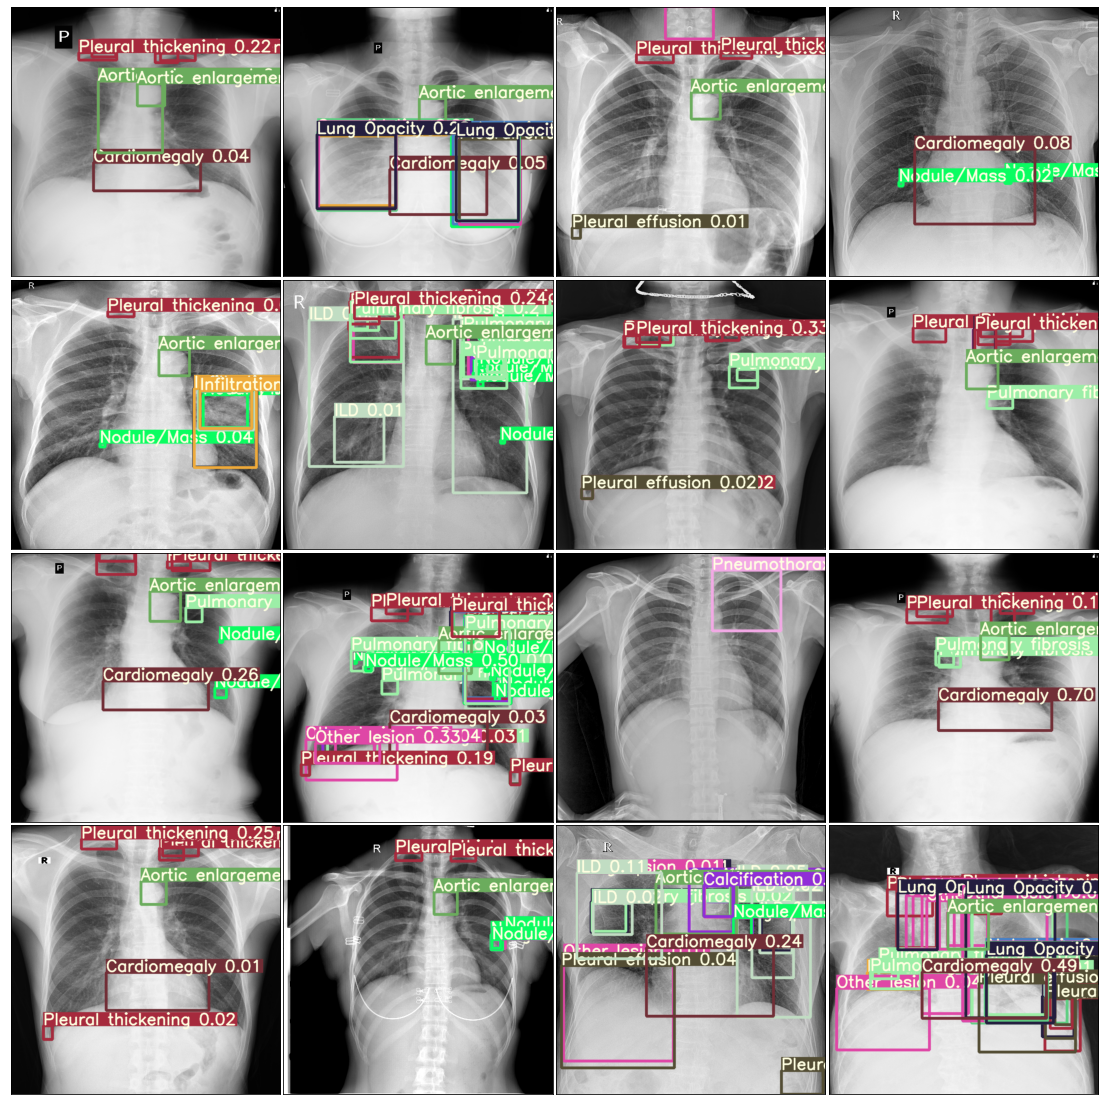

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
import cv2
from glob import glob
from tqdm import tqdm


files = glob('runs/detect/exp/*png')
for _ in range(3):
    row = 4
    col = 4
    grid_files = random.sample(files, row*col)
    images     = []
    for image_path in tqdm(grid_files):
        img          = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        images.append(img)

    fig = plt.figure(figsize=(col*5, row*5))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(col, row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [7]:
def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

In [8]:
# original
image_ids = []
PredictionStrings = []

for file_path in tqdm(glob('runs/detect/exp/labels/*txt')):
    image_id = file_path.split('/')[-1].split('.')[0]
    w, h = test_df.loc[test_df.image_id==image_id,['width', 'height']].values[0]
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
    data = data[:, [0, 5, 1, 2, 3, 4]]
    bboxes = list(np.round(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1), 1).astype(str))
    for idx in range(len(bboxes)):
        bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
    image_ids.append(image_id)
    PredictionStrings.append(' '.join(bboxes))

100%|██████████| 2990/2990 [00:06<00:00, 495.24it/s]


In [9]:
image_ids = []
PredictionStrings = []

for file_path in tqdm(glob('runs/detect/exp/labels/*txt')):  
    image_id = file_path.split('/')[-1].split('.')[0]
    w, h = test_df.loc[test_df.image_id==image_id,['width', 'height']].values[0]
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)

    
    data = data[:, [0, 5, 1, 2, 3, 4]]   # image_id, conf_score, BB_yolo
#     print(data)
#     break
    bboxes_voc = np.concatenate((data[:, :2].tolist(), np.round(yolo2voc(h, w, data[:, 2:]))), axis =1)   # image_id, conf_score, BB_VOC_format
#     print(bboxes_voc)
#     break

    for box in bboxes_voc:
        image_ids.append(image_id)
        PredictionStrings.append(box)

100%|██████████| 2990/2990 [00:05<00:00, 569.29it/s]


In [10]:
pred_df = pd.DataFrame({'image_id':image_ids,
                        'PredictionString':PredictionStrings})

pred_df['x_min'] = pred_df['PredictionString'].str.get(2)
pred_df['y_min'] = pred_df['PredictionString'].str.get(3)
pred_df['x_max'] = pred_df['PredictionString'].str.get(4)
pred_df['y_max'] = pred_df['PredictionString'].str.get(5)
pred_df['label'] = pred_df['PredictionString'].str.get(0)
pred_df['confidence_score'] = pred_df['PredictionString'].str.get(1)

pred_df.head()

image_id  \
0  52e9686ffccd0f4d3a6c58de8a12259b   
1  52e9686ffccd0f4d3a6c58de8a12259b   
2  52e9686ffccd0f4d3a6c58de8a12259b   
3  52e9686ffccd0f4d3a6c58de8a12259b   
4  52e9686ffccd0f4d3a6c58de8a12259b   

                                    PredictionString   x_min   y_min   x_max  \
0  [6.0, 0.010215800255537033, 387.0, 692.0, 765....   387.0   692.0   765.0   
1  [1.0, 0.010345499962568283, 427.0, 624.0, 990....   427.0   624.0   990.0   
2  [6.0, 0.01139070000499487, 1427.0, 546.0, 1571...  1427.0   546.0  1571.0   
3  [8.0, 0.011451699770987034, 1656.0, 1232.0, 16...  1656.0  1232.0  1692.0   
4  [6.0, 0.011535599827766418, 806.0, 1091.0, 986...   806.0  1091.0   986.0   

    y_max  label  confidence_score  
0  1041.0    6.0          0.010216  
1  1153.0    1.0          0.010345  
2   827.0    6.0          0.011391  
3  1277.0    8.0          0.011452  
4  1260.0    6.0          0.011536

In [11]:
pred_df.drop(['PredictionString'], axis=1, inplace=True)
pred_df.head()

image_id   x_min   y_min   x_max   y_max  label  \
0  52e9686ffccd0f4d3a6c58de8a12259b   387.0   692.0   765.0  1041.0    6.0   
1  52e9686ffccd0f4d3a6c58de8a12259b   427.0   624.0   990.0  1153.0    1.0   
2  52e9686ffccd0f4d3a6c58de8a12259b  1427.0   546.0  1571.0   827.0    6.0   
3  52e9686ffccd0f4d3a6c58de8a12259b  1656.0  1232.0  1692.0  1277.0    8.0   
4  52e9686ffccd0f4d3a6c58de8a12259b   806.0  1091.0   986.0  1260.0    6.0   

   confidence_score  
0          0.010216  
1          0.010345  
2          0.011391  
3          0.011452  
4          0.011536

In [12]:
pred_df.describe()

x_min         y_min         x_max         y_max         label  \
count  41034.000000  41034.000000  41034.000000  41034.000000  41034.000000   
mean    1032.306209    940.034825   1367.059536   1287.071648      7.982429   
std      574.282157    560.040497    576.195537    621.376097      3.839112   
min        0.000000      0.000000     12.000000     43.000000      0.000000   
25%      556.000000    476.000000    894.000000    779.000000      6.000000   
50%     1002.000000    824.000000   1386.000000   1232.000000      9.000000   
75%     1465.000000   1340.000000   1812.000000   1782.000000     11.000000   
max     2875.000000   3255.000000   3072.000000   3408.000000     13.000000   

       confidence_score  
count      41034.000000  
mean           0.097826  
std            0.164555  
min            0.010010  
25%            0.015808  
50%            0.030014  
75%            0.086487  
max            0.876465

In [13]:
sub_df = pd.merge(test_df, pred_df, on = 'image_id', how = 'left').fillna("14 1 0 0 1 1")
print(len(sub_df))

sub_df.head()

41044


image_id  width  height x_min y_min x_max y_max  \
0  83caa8a85e03606cf57e49147d7ac569   2304    2880  1273   461  1480   546   
1  83caa8a85e03606cf57e49147d7ac569   2304    2880  1076   748  1332  1007   
2  83caa8a85e03606cf57e49147d7ac569   2304    2880   792  1159  1746  1530   
3  7550347fa2bb96c2354a3716dfa3a69c   2538    3095   803  1451  1140  2291   
4  7550347fa2bb96c2354a3716dfa3a69c   2538    3095   273  1644   699  2218   

  label confidence_score  
0    11         0.018692  
1     0          0.09552  
2     3         0.771973  
3     9        0.0152512  
4     5        0.0249939

In [14]:
sub_df.drop(['width', 'height'], axis=1, inplace=True)
sub_df.to_csv('/kaggle/working/predictions_test_3000.csv',index = False)

sub_df.tail()

image_id x_min y_min x_max y_max label  \
41039  14da9051525bd2504dd56938f92644ef   460   522   720   636    11   
41040  14da9051525bd2504dd56938f92644ef  1215   513  1507   626    11   
41041  14da9051525bd2504dd56938f92644ef   537   522   810   589    11   
41042  14da9051525bd2504dd56938f92644ef  1153   513  1422   579    11   
41043  14da9051525bd2504dd56938f92644ef   993   812  1200  1035     0   

      confidence_score  
41039        0.0144958  
41040         0.017746  
41041        0.0567932  
41042        0.0603333  
41043         0.344482

In [15]:


%cd /kaggle/working

from IPython.display import FileLink 
FileLink(r'predictions_test_3000.csv')



/kaggle/working


/kaggle/working/predictions_test_3000.csv